<h1> ITE </h1>

This notebook contains the required codes to execute approximate imaginary time evolution on a Quantum Device (simulated or otherwise) using IBM's Qiskit API. The Hamiltonian we reference was proposed by Smith et. al. in 2019$^{[1]}$. It is related to the Heisenberg model and has interesting physical uses. We will estimate the ground state energies of our Hamiltonians (for various $J$ and $U$) by approximating the operator $e^{\tau \mathcal{H}}$. Our Hamiltonian is shown below,

$$\mathcal{H} = J \sum_{<ij>} \sigma_x^i \sigma_x^j + \sigma_y^i \sigma_y^j + U \sum_{<ij>} \sigma_z^i \sigma_z^j + B \sum_i \sigma_z$$

Here, J, U and B are scalars and the $\sigma_l^i$ is the famililar Pauli-spin operator applied to site $i$. In order to simplify the analysis we will set $B=1.0$ and vary $J,U$.  

We will use the ansatz suggested in Peng 2021$^{[2]}$, expressed in big-endian.

$$|\psi \rangle = C_z^{0,1}C_z^{1,2}C_z^{2,3}R_y^0(\theta_0)R_y^2(\theta_1)R_y^3(\pi)|1100\rangle$$

<h2> References </h2>

1] Adam Smith, M. Kim, Frank Pollmann, and Johannes Knolle.  Simulating quantum many-bodydynamics on a current digital quantum computer.<em>npj Quantum Information</em>, 5, 12 2019

2] Bo Peng and Karol Kowalski.  Variational quantum solver employing the pds energy functional. <em>Quantum</em>, 5:473, 06 2021.



------------------------------

<h2> Imports </h2>

In [1]:
import Hamiltonians.hamiltonians as ham
import Hamiltonians.helper as helper
import numpy as np
import qiskit as qm

from itertools import combinations
from matplotlib import pyplot as plt

<h2> Setting up Analytical Analysis </h2>

In [2]:
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}

In [3]:
def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix

In [4]:
def preparePsiNumerical(theta):
    '''
        represent ansatz in the Z computational basis
    '''
    Initial = np.kron(ket0,np.kron(ket0,np.kron(ket0,ket0)))
    Layer1  = np.kron(PauliX,np.kron(PauliX,np.kron(PauliI,PauliI)))
    Layer2  = np.kron(RY(theta[0]),np.kron(PauliI,np.kron(RY(theta[1]),RY(np.pi))))
    Layer3  = np.kron(cz(),cz())
    Layer4  = np.kron(PauliI,np.kron(cz(),PauliI))
    return Layer4@Layer3@Layer2@Layer1@Initial

In [5]:
def hamiltonianMatrix(j,u,b=1.0,n=4):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for bits in combos:
        for k in range(3):
            A = [PauliI for i in range(n)]
            A[bits[0]] = PauliVec[k]
            A[bits[1]] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                add = np.kron(add, A[qbit])
            H += x*add
            
    for i in range(n):
        A = [PauliI for i in range(n)]
        A[i] = PauliZ
        add = [1]
        for qbit in range(n):
                add = np.kron(add, A[qbit])
        H += b * add
    return H

In [6]:
x = np.linspace(0,1,12)
Js, Us = np.meshgrid(x,x)
Gnd_analytical = np.zeros(Js.shape, dtype=complex)
for i in range(len(Js)):
    for j in range(len(Js[i])):
        Gnd_analytical[i,j] = np.min(np.linalg.eig(hamiltonianMatrix(Js[i,j], Us[i,j]))[0])

Text(0.5, 1.0, 'Ground state energies in a.u.')

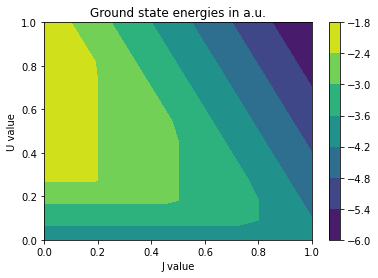

In [7]:
plt.contourf(Js, Us, Gnd_analytical.real)
plt.colorbar()
plt.xlabel("J value")
plt.ylabel("U value")
plt.title("Ground state energies in a.u.")

These are the numerical ground state eigenvalue for a test 4-site Hamiltonian. Now, we will try to reproduce the PES by approximating ITE.

---------------------------------

<h2> ITE Step 1) Set up Quantum Device and Ansatz </h2>

In [8]:
'''

Use this block if you would like to run on an IBM Quantum device 

IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

'''
from qiskit import IBMQ, Aer

backend = Aer.get_backend('qasm_simulator')
shots = 2**13
thetaTest = np.array([-2.0,1.0])

def preparePsi(theta):
    qc = qm.QuantumCircuit(4,4)
    qc.x(0)
    qc.x(1)
    qc.ry(np.pi, 3)
    qc.ry(theta[1],2)
    qc.ry(theta[0],0)
    qc.cz(2,3)
    qc.cz(1,2)
    qc.cz(0,1)
    return qc

<h2> ITE Step 2) Collect QWC Groups and Measure Computational Basis </h2>

In [9]:
L,C = helper.heisenberg_letters(1,1,1,4)
Hamil = ham.Hamiltonian(L,C)
expHamil = Hamil.exp(15)
qwc_bases = expHamil.grouping()

In [10]:
circs = []
for i in range(len(qwc_bases)):
    base = qwc_bases[i]
    qc = preparePsi(thetaTest)
    for i in range(len(base)):
        
        #rotate qubits into the correct computational basis
        if base[i] == "X":
            qc.h(i)
        elif base[i] == "Y":
            qc.rx(np.pi/2,i)
    
        qc.measure(i,i)
    circs += [qc]

job = qm.execute(circs, shots=shots,backend=backend)
cal_results = job.result()


<h2> ITE Step 3) Calculate the expectation values of available Pauli observables </h2>

In [11]:
from itertools import product

def stringToBasisState(string):
    '''
        Convert a Pauli Word to an array of its eigenvalues
    
    '''
    ket0 = np.array([1.,0.])
    ket1 = np.array([0., 1.])
    if(len(string)>2):
        if(string[0]=="1"):
            return np.kron(ket1, stringToBasisState(string[1:]))
        else:
            return np.kron(ket0, stringToBasisState(string[1:]))
    else:
        A = [ket0, ket0]
        if(string[0] == "1"):
            A[0] = ket1
        if(string[1] == "1"):
            A[1] = ket1
        return np.kron(A[0], A[1])
    
def expectationFromGroupMeasurment(measurement, obs):
    
    '''
        Convert a computational basis measurement to the expectation value of an observable
    
    ''' 
    pauliEigen = np.array([1.,-1.])
    identityEigen = np.array([1.,1.])
    eigen = [pauliEigen]*4
    for i in range(len(eigen)):
        if(obs[i]=="I"):
            eigen[i] = identityEigen
    eigen = np.kron(np.kron(np.kron(eigen[0], eigen[1]),eigen[2]), eigen[3])
    return measurement @ eigen
    
keys = qwc_bases
dict_results = {}
for i in range(len(cal_results.results)):
    res = cal_results.results[i].data.counts
    calculations = np.zeros(16)
    for place in res:
        st = bin(int(place,16))[2:]
        st = str(st)
        add = "0"*int(4-len(st))
        st = add+st
        #flip for Qiskit endian convention
        basis = stringToBasisState(st[::-1])
        calculations += basis * res[place]/shots
    dict_results[keys[i]] = calculations


expectation_values = {}
for key in dict_results:
    options = ["ZI"]*4
    for wire in range(len(key)):
        if(key[wire] == "X"):
            options[wire]= "XI"
        elif(key[wire] == "Y"):
            options[wire]= "YI"
    products = list(product(*options))
    for product_ in products:
        if not product_ in expectation_values:
            p = "".join(product_)
            expectation_values[p] = expectationFromGroupMeasurment(dict_results[key], p)

<h2> ITE Step 4) Evaluate ITE using calculated expectations </h2>

In [14]:
def NumerHamil(tau,J,U,B,order=13):
    '''
        Numerator Hamiltonian (ITE propagator)
    
    '''
    L, C = helper.heisenberg_letters(J, U, B,4)
    HA = ham.Hamiltonian(L, C)
    P = HA.mult_scalar((-0.125)*tau)
    P = P.exp(order)
    P = P.power(8)
    #note hermitian ---> do not need P dagger
    C = P.multiply(HA.multiply(P))
    return C

def DenomHamil(tau,J,U,B,order=13):
    '''
        Used to normalize
    
    '''
    L, C = helper.heisenberg_letters(J,U,B,4)
    HA = ham.Hamiltonian(L, C)
    P = HA.mult_scalar(-0.25*tau)
    P = P.exp(order)
    P = P.power(8)
    return P


def CostHamil(Hamil, energies):
    '''
        Calculate the energy of a Hamiltonian
    
    '''
    e = 0
    for i in range(len(Hamil.letters)):
        e+=Hamil.coeffs[i]*energies[Hamil.letters[i][::-1]]
    return float(e.real)

def CostSys(tau, J,U,B,energies):
    '''
        Calculate the energy for a specific set of J, U, and B values
        given a dictionary with Pauli expectation measurments
        
    '''
    numerHamil = NumerHamil(tau,J,U,B).clean()
    denomHamil = DenomHamil(tau,J,U,B).clean()
    eNumer = CostHamil(numerHamil, energies)
    eDenom = CostHamil(denomHamil, energies)
    return (eNumer / eDenom)


In [15]:
Gnd_QC = np.zeros(Js.shape)
for i in range(len(Js)):
    print("-------------")
    print("Round: ", i ," of ", len(Js))
    for j in range(len(Js[i])):  
        Gnd_QC[i,j] = CostSys(2.5,Js[i,j],Us[i,j],1,expectation_values)

-------------
Round:  0  of  12
-------------
Round:  1  of  12
-------------
Round:  2  of  12
-------------
Round:  3  of  12
-------------
Round:  4  of  12
-------------
Round:  5  of  12
-------------
Round:  6  of  12
-------------
Round:  7  of  12
-------------
Round:  8  of  12
-------------
Round:  9  of  12
-------------
Round:  10  of  12
-------------
Round:  11  of  12


<h1> Compare Analytical to ITE </h1>

In [16]:
MSE = np.mean((Gnd_QC-Gnd_analytical)**2)
print("MSE: ", MSE.round(3).real)

MSE:  0.004


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


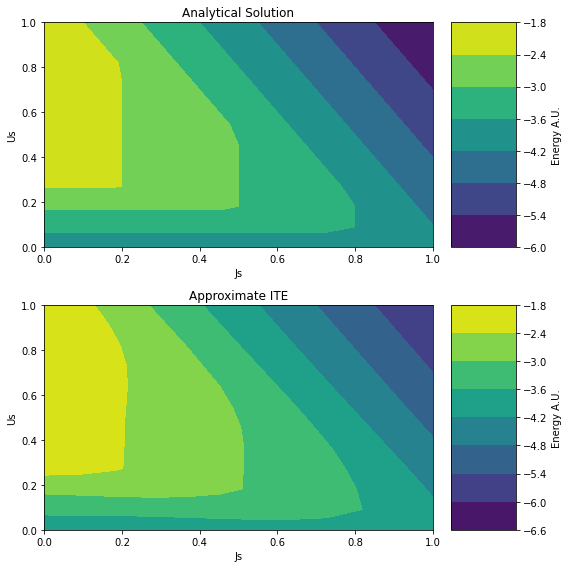

In [17]:
fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios': [6, 1]})
fig.set_size_inches(8,8)
surf1 = ax[0,0].contourf(Js, Us, Gnd_analytical)
surf2 = ax[1,0].contourf(Js, Us, Gnd_QC)
surfs = [surf1, surf2]
ax[0,0].set_title("Analytical Solution")
ax[1,0].set_title("Approximate ITE")

for i in [0,1]:
    
    ax[i,0].set_xlabel("Js")
    ax[i,0].set_ylabel("Us")
    cbar = fig.colorbar(surfs[i], ax[i,1])
    cbar.set_label("Energy A.U.")
fig.tight_layout()


<h1> Analyzing Other Observables (example Magnetization) </h1>

Here we demonstrate using ITE to evaluate the expectation values of an observable $\mathcal{O}$ on the ground state. In other words, once we estimate the ground state using imaginary time evolution we then evaluate the inner product 
$$\langle \psi_{ITE} | \mathcal{O} | \psi_{ITE} \rangle$$
which we hope approximates
$$\langle \psi_{gnd} | \mathcal{O} | \psi_{gnd} \rangle = \langle \mathcal{O} \rangle$$

--------

In this example, we will evaluate the expectation value of the magnetization operator,
$$\mathcal{M} = \sum_i {\sigma_i}$$
when acting on the different ground states corresponding to different $J,U$ pairs. One simply applies the ITE propagator to the ansatz and takes the inner product with $\mathcal{M}$. For instance,
$$\lim_{\tau \rightarrow \infty} A(\tau) \langle \psi_0 | e^{-\tau \mathcal{H}} \mathcal{M} e^{-\tau \mathcal{H}} | \psi_0 \rangle = \langle \mathcal{M} \rangle$$
where $A(\tau)$ is the normalization constant defined as $$1 / \sqrt{ \langle \psi_0 | e^{-2\tau \mathcal{H}} | \psi_0 \rangle }$$ Note that all the $J$ and $U$ dependence is baked into the propagator.


In [18]:
#define the magnetization observable using the Hamiltonian class
magObservable = ham.Hamiltonian(["ZIII", "IZII","IIZI","IIIZ"], [1. for i in range(4)])

def expectationObservable(observable, tau,J,U,B,energies):
    '''
        Calculate the expectation of the magnetization for a specific set of J, U, and B values
        given a dictionary with Pauli expectation measurments
        
    '''
    L, C = helper.heisenberg_letters(J, U, B, 4)
    HA = ham.Hamiltonian(L, C)
    P = HA.mult_scalar((-0.125)*tau)
    P = P.exp(13)
    P = P.power(8)
    numerHamil = P.multiply(observable.multiply(P)).condense().clean()
    denomHamil = DenomHamil(tau,J,U,B).clean()
    eNumer = CostHamil(numerHamil, energies)
    eDenom = CostHamil(denomHamil, energies)
    return (eNumer / eDenom)


In [19]:
magJs = np.linspace(0,1,6)
magJs, magUs = np.meshgrid(magJs, magJs)
Gnd_magnetization_QC = np.zeros(magJs.shape)
for i in range(len(magJs)):
    print("-------------")
    print("Round: ", i ," of ", len(magJs))
    for j in range(len(magJs[i])):  
        Gnd_magnetization_QC[i,j] = expectationObservable(magObservable,
                                                                   2.5,magJs[i,j],magUs[i,j],1,expectation_values)
        

-------------
Round:  0  of  6
-------------
Round:  1  of  6
-------------
Round:  2  of  6
-------------
Round:  3  of  6
-------------
Round:  4  of  6
-------------
Round:  5  of  6


In this case we can express $e^{-\tau \mathcal{H}} \mathcal{M} e^{-\tau \mathcal{H}}$ as a linear combination of Pauli Strings which we have already measured. For an observable $\mathcal{O}$ where $e^{-\tau \mathcal{H}} \mathcal{O} e^{-\tau \mathcal{H}}$ is spanned by the Pauli Strings measured during the energy calculations, we can estimate its expectation value on the ground state without additional quantum circuits. However, in general more quantum circuits may be required.

---------------

Finally, let's compare this to the analytical values

In [20]:
#higher res for the analytical
magJsA = np.linspace(0,1,50)
magJsA, magUsA = np.meshgrid(magJsA, magJsA)
Gnd_magnetization_Analytical = np.zeros(magJsA.shape)

#define the magnetization observable
mag = np.zeros((16,16), dtype=complex)
for i in range(4):
    A = [PauliI] * 4
    A[i] = PauliZ
    mag += np.kron(A[0], np.kron(A[1], np.kron(A[2], A[3])))


for i in range(len(magJsA)):
    if(i%5==0):
        print("-------------")
        print("Round: ", i ," of ", len(magJsA))
    for j in range(len(magJsA[i])): 
        #first get the numerical ground state
        ham = hamiltonianMatrix(magJsA[i,j], magUsA[i,j])
        eigns = np.linalg.eigh(ham)
        min_ = np.argmin(eigns[0])
        gnd_vector = eigns[1][:,min_]
        Gnd_magnetization_Analytical[i,j] = (np.conjugate(gnd_vector).T @ mag @ gnd_vector).real
        

-------------
Round:  0  of  50
-------------
Round:  5  of  50
-------------
Round:  10  of  50
-------------
Round:  15  of  50
-------------
Round:  20  of  50
-------------
Round:  25  of  50
-------------
Round:  30  of  50
-------------
Round:  35  of  50
-------------
Round:  40  of  50
-------------
Round:  45  of  50


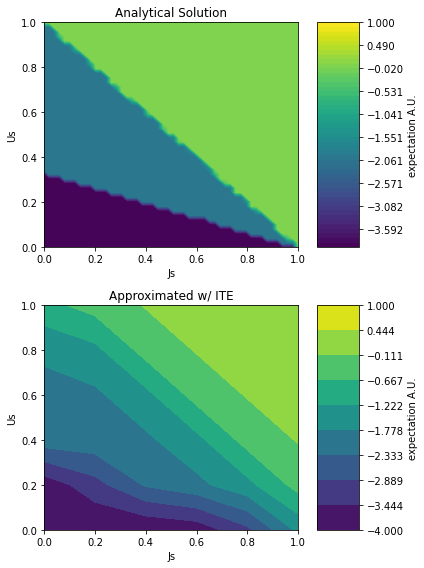

In [21]:
fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios': [6, 1]})
fig.set_size_inches(6,8)
surf1 = ax[0,0].contourf(magJsA, magUsA, Gnd_magnetization_Analytical, levels = np.linspace(-4,1))
surf2 = ax[1,0].contourf(magJs, magUs, Gnd_magnetization_QC, levels = np.linspace(-4,1,10))
surfs = [surf1, surf2]
ax[0,0].set_title("Analytical Solution")
ax[1,0].set_title("Approximated w/ ITE")

for i in [0,1]:
    
    ax[i,0].set_xlabel("Js")
    ax[i,0].set_ylabel("Us")
    cbar = fig.colorbar(surfs[i], ax[i,1])
    cbar.set_label("expectation A.U.")
fig.tight_layout()